# Object detection with OWLv2

OWL model is a minimal modification of OpenAI's model to do zero-shot object detection.

Ref. Paper: [OWL v2](https://arxiv.org/pdf/2306.09683.pdf), [OWL ViT](https://arxiv.org/pdf/2205.06230.pdf), [ViT](https://arxiv.org/pdf/2010.11929.pdf), [CLIP](https://arxiv.org/pdf/2103.00020.pdf)

Ref. github: [transformers](https://github.com/huggingface/transformers/blob/main/src/transformers/models/owlv2), [google-research](https://github.com/google-research/scenic/tree/main/scenic/projects/owl_vit)

Ref. Notebooks: [NielsRogge](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/OWLv2/Zero_and_one_shot_object_detection_with_OWLv2.ipynb), [google-research](https://github.com/google-research/scenic/blob/main/scenic/projects/owl_vit/notebooks/OWL_ViT_minimal_example.ipynb)

# Download Dependencies

In [13]:
# !../scripts/setup-env.sh
# !pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -e ../libs

# Download Datasets
Amazon bin images (aws bucket - 'aft-vbi-pds', filtered by [IK index file](../libs/binsense/resources/ik_data_index.csv))\
Annotated Amazon bin images from roboflow (nitesh-c-eszzc/binsense_segments)

In [14]:
from binsense.dataprep import metadata, downloader
from binsense import config as cfg
from binsense.roboflow_wrapper import RoboProj
from binsense.dataset_util import COCODatasetBuilder

import roboflow, os

# download Amazon bin images & meta-data
downloader.download()

# download Roboflow project
# creates a config file (~/.config/roboflow/config.json) after you login first time
roboflow.login()
rf = roboflow.Roboflow()
proj_binsense =  RoboProj(
    rf, 
    rf_proj=rf.project(f'{cfg.BIN_ROBO_WORKSPACE}/{cfg.BIN_ROBO_PROJECT}'),
    proj_ver=2
)
ds_binsense = proj_binsense.download(
    dataset_path=cfg.BIN_ROBO_DOWNLOAD_DIR,
    dataset_format='coco')
print("Downloaded dataset paths")
for i in range(0, len(ds_binsense.get_all_images_dir())):
    print(ds_binsense.get_all_images_dir()[i], ds_binsense.get_all_labels_dir()[i])

bin_df, item_df = metadata.load()
item_df.sort_values(by="item_id", inplace=True)

# to handle roboflow renames
def imgname_extractor(name: str) -> str:
    imgname, extn = os.path.splitext(name)
    clean_img_name = imgname.split('_jpg')[0].strip()
    return f'{clean_img_name}{extn}'
train_coco_ds = COCODatasetBuilder.build_from_file(
    ds_binsense.get_labels_dir('train'),
    image_name_extractor=imgname_extractor)
annotations = {}
for image_data in train_coco_ds.get_images():
    bboxes = train_coco_ds.get_bboxes(image_data.name)
    annotations[image_data.name] = [bbox.label for bbox in bboxes]

def annotation_exist(bin_id, item_id) -> bool:
    return f"{bin_id}.jpg" in annotations \
        and item_id in annotations[f"{bin_id}.jpg"]

item_df['annotated'] = item_df.apply(lambda r: annotation_exist(r.bin_id, r.item_id), axis=1)
print('#items annotated are ', item_df.query('annotated == True').shape[0])
item_df.head()

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).



Extracting Dataset Version Zip to /Users/n0c09jf/code/github/binsense/_data/robo in coco:: 100%|██████████| 45/45 [00:00<00:00, 312.28it/s]


Downloaded dataset paths
/Users/n0c09jf/code/github/binsense/_data/robo/valid /Users/n0c09jf/code/github/binsense/_data/robo/valid/_annotations.coco.json
/Users/n0c09jf/code/github/binsense/_data/robo/test /Users/n0c09jf/code/github/binsense/_data/robo/test/_annotations.coco.json
/Users/n0c09jf/code/github/binsense/_data/robo/train /Users/n0c09jf/code/github/binsense/_data/robo/train/_annotations.coco.json
#items annotated are  34


bin_id     item_id                                          item_name  \
4852  00638  0002624028  THE KREMLIN'S DILEMMA: The Struggle for Human ...   
7267  10180  0061986623                Another Summer: A Beach House Novel   
5310  07214  0062080644  Super Immunity: The Essential Nutrition Guide ...   
7260  07215  0062080644  Super Immunity: The Essential Nutrition Guide ...   
7268  10180  0062111736                     Folly Beach: A Lowcountry Tale   

      item_qty  item_length item_length_unit  item_width item_width_unit  \
4852         1     8.267717               IN    5.669291              IN   
7267         1     7.900000               IN    5.200000              IN   
5310         3     7.795276               IN    5.196850              IN   
7260         3     7.795276               IN    5.196850              IN   
7268         1     7.900000               IN    5.300000              IN   

      item_height item_height_unit  item_weight item_weight_unit  annotated  
4852     1.496063               IN     1.190000           pounds      False  
7267     1.100000               IN     0.950000           pounds      False  
5310     0.866142               IN     0.485012           pounds      False  
7260     0.866142               IN     0.485012           pounds      False  
7268     1.200000               IN     0.550000           pounds      False

## Load model and processor

OWLv2 checkpoint from the [hub](https://huggingface.co/models?other=owlv2). Based on the reference notebook, ensemble checkpoint performs best. Larger checkpoints are available.

In [15]:
from binsense.owlv2 import hugg_loader as hloader
from binsense.owlv2.model import Owlv2ForObjectDetection
from binsense.owlv2.config import Owlv2Config
from binsense.owlv2.processor import Owlv2ImageProcessor

# from transformers import Owlv2Processor, Owlv2ForObjectDetection
import numpy as np
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD
from PIL import Image
from matplotlib import pyplot as plt
import cv2 as cv

processor = Owlv2ImageProcessor()
owl_model_cfg = Owlv2Config(**hloader.load_owlv2model_config())
model = Owlv2ForObjectDetection(owl_model_cfg)
model.load_state_dict(hloader.load_owlv2model_statedict())
model.eval()


# processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
# model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

# this is to get the pre-processed image for visualization
#   resized and padded before normalizing
def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

# draws the bounding boxes on the cv image
# and plots it in the grid with each image+bbox per grid
def show_bbox_ingrid(cv_img, box_scores, grid, title=None):
    rows, cols = grid
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    for i in range(0, rows):
        for j in range(0, cols):
            bi = i*cols+j
            if bi >= len(box_scores):
                continue
            
            draw_img = cv_img.copy()
            box = [int(k) for k in box_scores[bi][0].tolist()]
            draw_img = cv.rectangle(draw_img, box[:2], box[2:], (0,0,255), 5)
            axs[i][j].imshow(draw_img, cmap = plt.cm.Spectral)
            axs[i][j].text(0, 0,
                f'Score: {box_scores[bi][1]:1.3f}',
                ha='left',
                va='top',
                color='black',
                bbox={
                    'facecolor': 'white',
                    'alpha': 0,
                    # 'edgecolor': 'lime',
                    'boxstyle': 'square,pad=.1',
                })
    if title:
        fig.suptitle(title)
    plt.show()

## Sample images for OwlV2 model
Sample few set of 3 bin images with same items. We will pick one or two sets and then annotate them in roboflow and run the model inference.

sample: ['B019UGWNMM', '05029', ['104298,05030,05028,104299,104297']]


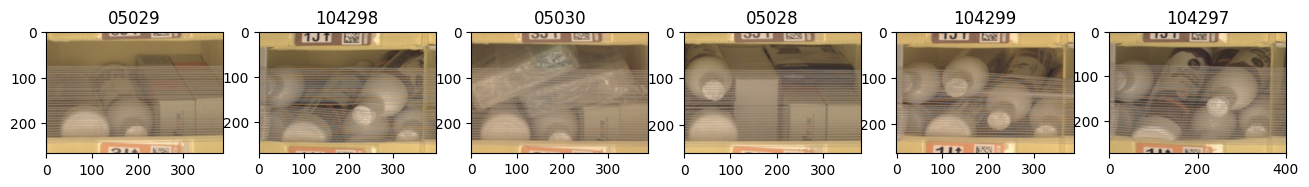

In [16]:
from binsense import config as cfg
from matplotlib import pyplot as plt
from PIL import Image

import os

item_nbins_df = item_df.groupby(['item_id'])['bin_id'].nunique().reset_index(name="bins")
annotated_items_df = item_df.query('annotated')[['bin_id', 'item_id']]

# lets take a random item which exists in more than one bin to do the analysis
def to_bin_image(bin_id):
    return Image.open(os.path.join(cfg.BIN_S3_DOWNLOAD_IMAGES_DIR, f'{bin_id}.jpg'))

def show_sample(sampled_bins):
    cols = len(sampled_bins)
    fig, axs = plt.subplots(1, cols, figsize=(16,4))
    if cols == 1:
        axs = [axs]
    for i, bin_id in enumerate(sampled_bins):
        # show images row
        img = to_bin_image(bin_id)
        axs[i].imshow(img, cmap = plt.cm.Spectral)
        axs[i].set_title(bin_id)
    plt.show()

def run_sample():
    query_rec = annotated_items_df.sample(1).iloc[0]
    sampled_items_df = item_nbins_df[ (item_nbins_df.bins >= 2) & (item_nbins_df.item_id == query_rec['item_id']) ]
    if len(sampled_items_df) > 0:
        sampled_item_id = sampled_items_df.sample(1).iloc[0]['item_id']
        sampled_bins = item_df[ (item_df.item_id == sampled_item_id) & (~item_df.annotated)]['bin_id'].unique()
        print(f"sample: ['{query_rec['item_id']}', '{query_rec['bin_id']}', ['{','.join(sampled_bins)}']]")
        show_sample([query_rec['bin_id'], *sampled_bins])
    else:
        print(f"couldn't sample for {query_rec['item_id']}")

run_sample()

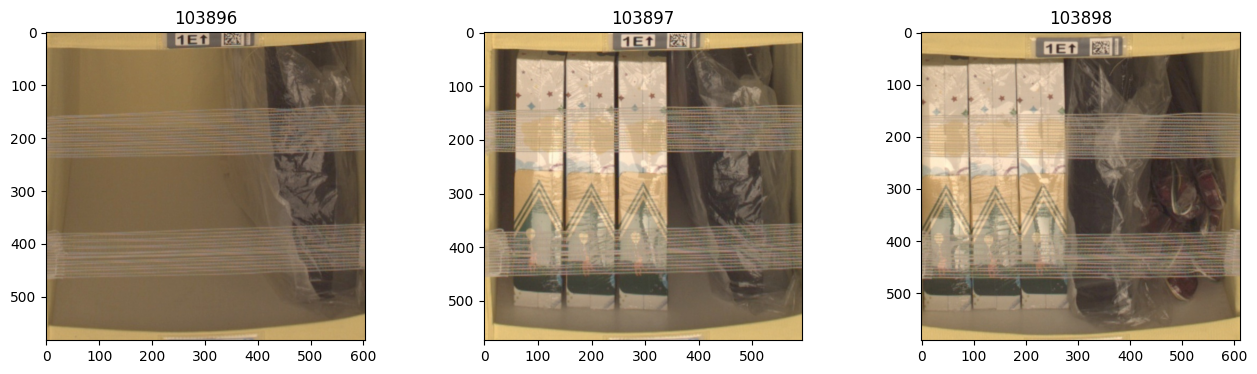

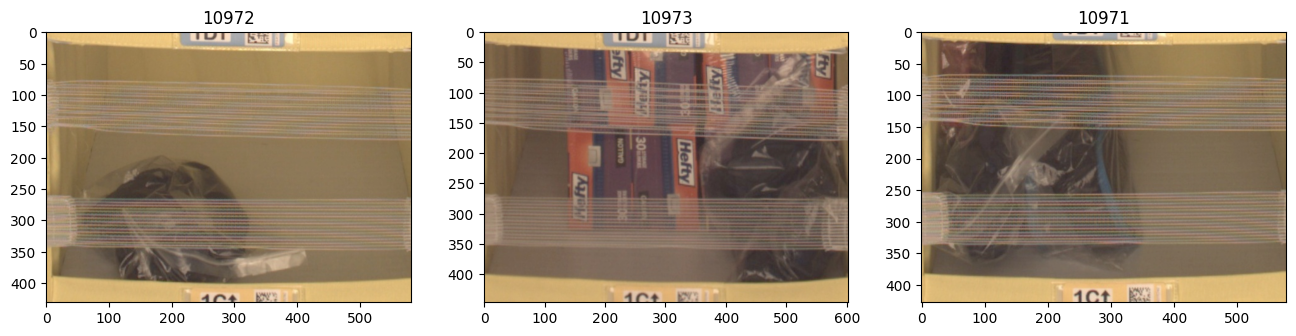

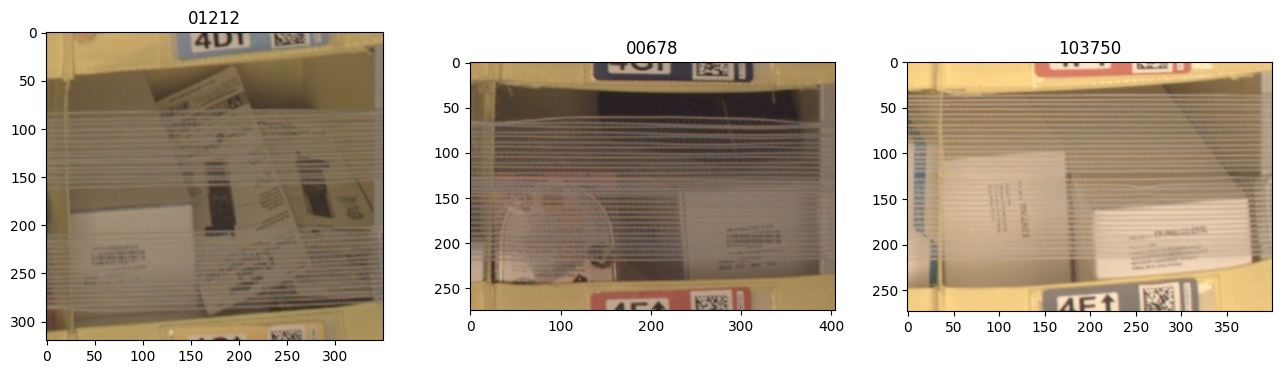

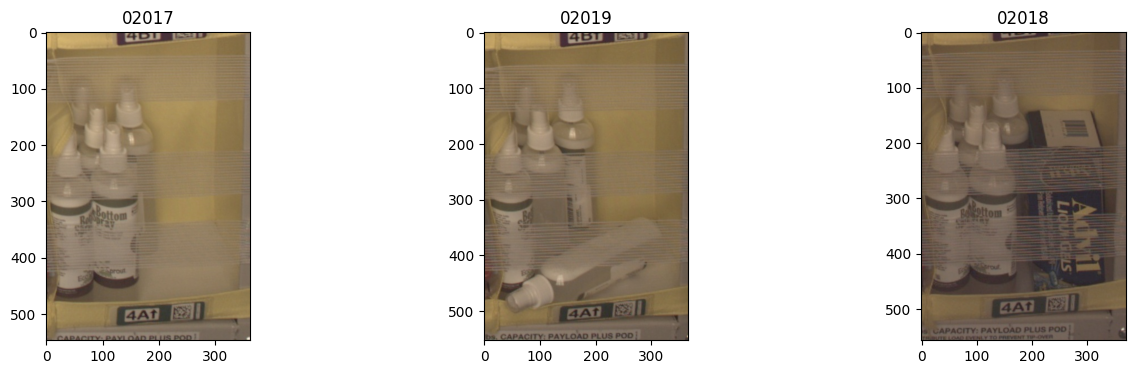

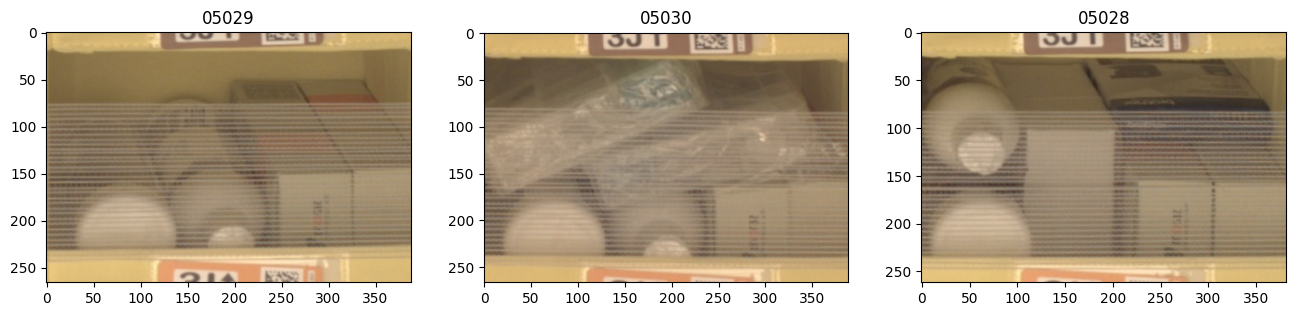

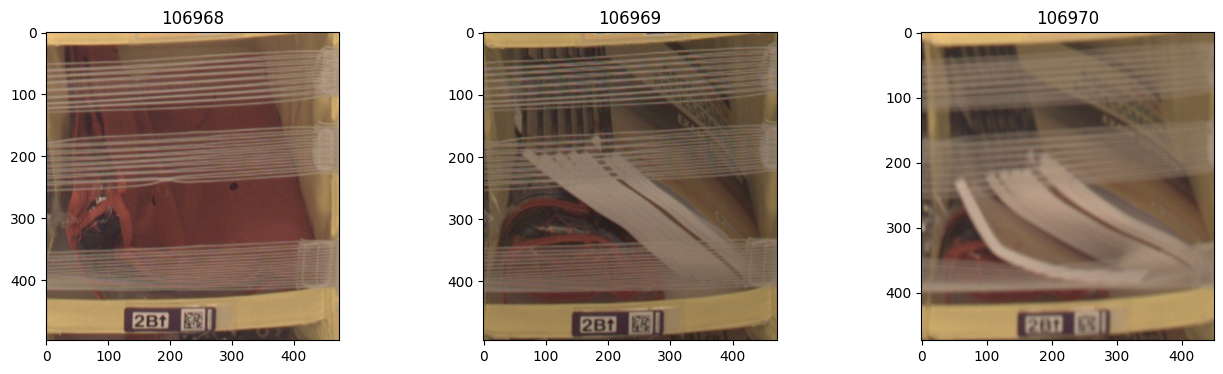

In [17]:
# ran the samples multiple items to arrive these sets which we will explore.
bin_queries = [
    # ['B00GZPF4FA', '100831', ['100832', '100833']],
    ['B004MF4RNK', '103896', ['103897', '103898']],
    ['B00R0P3JFG', '10972', ['10973', '10971']],
    ['B01AXI796G', '01212', ['00678', '103750']],
    ['B005GQ6606', '02017', ['02019', '02018']],
    ['B00WGLZGDW', '05029', ['05030', '05028']],
    ['B00XKOLGQU', '106968', ['106969','106970']]
]
for sample in bin_queries:
    show_sample([sample[1], *sample[2]])

## Prepare image and queries for the model

We will be doing the image based queries based on the samples. Prepare the images for the queries.\
Query Bin: 100832 (extract the query item from this bin using roboflow) \
Target Bin: 100831

In [18]:
from binsense.dataset_util import BoundingBox
from binsense.dataset_util import Dataset as BinsenseDataset
from binsense.img_utils import convert_cxy_xy_and_scale
from typing import List
from PIL import Image
import cv2

def lookup_bbox(bin_id: str, item_id: str, ds: BinsenseDataset) -> List[BoundingBox]:
    bboxes = ds.get_bboxes(f'{bin_id}.jpg')
    fbboxes = []
    for bbox in bboxes:
        if bbox.label == item_id:
            fbboxes.append(bbox)
    fbboxes = sorted(fbboxes, key=lambda box: box.area, reverse=True)
    return fbboxes

#crop by bbox
def crop_by_bbox(bin_id: str, bbox_data: BoundingBox) -> Image:
    query_image = to_bin_image(bin_id)
    box_xy = convert_cxy_xy_and_scale([bbox_data.to_array()], (query_image.width, query_image.height))[0]
    query_item_image = query_image.crop(box_xy)
    return query_item_image

#crop by segment
def crop_by_segment(bin_id: str, bbox_data: BoundingBox) -> Image:
    query_image = to_bin_image(bin_id)
    box_xy = convert_cxy_xy_and_scale([bbox_data.to_array()], (query_image.width, query_image.height))[0]
    
    # scale the segment
    cv_img = np.array(query_image)
    segment = bbox_data.segmentation[0]
    segment[:,0] = segment[:,0] * cv_img.shape[0]
    segment[:,1] = segment[:,1] * cv_img.shape[1]
    
    # create mask based on polygon (segment)
    mask = np.zeros((cv_img.shape[0], cv_img.shape[1]))
    cv2.fillConvexPoly(mask, segment.astype("int"), 1)
    mask = mask > 0
    # apply mask on the image to extract segment
    out_img = np.full_like(cv_img, 255/2)
    out_img[mask] = cv_img[mask]
    
    # crop the image
    query_item_image = Image.fromarray(out_img) 
    return query_item_image.crop(box_xy)

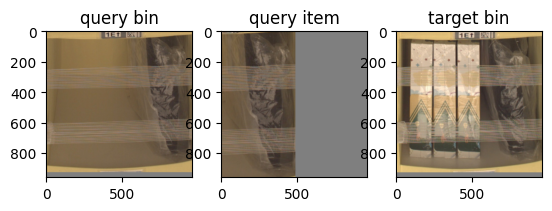

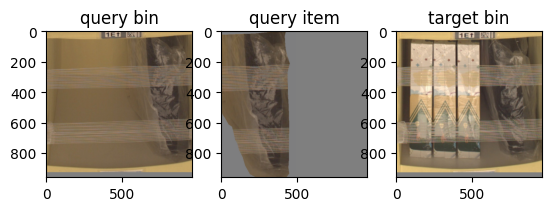

In [19]:
from matplotlib import pyplot as plt

def prepare_by_bboxcrop(query):
    # Load the Query & Target bin image
    query_bin_image = to_bin_image(query[1])
    query_item_bbox = lookup_bbox(query[1], query[0], train_coco_ds)[0]
    query_item_image = crop_by_bbox(query[1], query_item_bbox)
    target_bin_images = [to_bin_image(bin) for bin in query[2]]

    qbin_image = processor.preprocess(images=query_bin_image)["pixel_values"][0]
    qitem_image = processor.preprocess(images=query_item_image)["pixel_values"][0]
    tbin_images = processor.preprocess(images=target_bin_images)["pixel_values"]

    ow, oh = query_bin_image.width, query_bin_image.height
    cx, cy, w, h = query_item_bbox.to_array()
    cx, cy, w, h = cx * ow, cy * oh, w * ow, h * oh
    cx, cy = w/2, h/2
    m = max(w, h)
    cx, cy, w, h = cx / m, cy / m, w / m, h / m
    bbox = np.array([cx, cy, w, h])
    
    return (qitem_image, qbin_image, tbin_images, bbox)

def prepare_by_bboxseg(query):
    # Load the Query & Target bin image
    query_bin_image = to_bin_image(query[1])
    query_item_bbox = lookup_bbox(query[1], query[0], train_coco_ds)[0]
    query_item_image = crop_by_segment(query[1], query_item_bbox)
    target_bin_images = [to_bin_image(bin) for bin in query[2]]

    qbin_image = processor.preprocess(images=query_bin_image)["pixel_values"][0]
    qitem_image = processor.preprocess(images=query_item_image)["pixel_values"][0]
    tbin_images = processor.preprocess(images=target_bin_images)["pixel_values"]
    
    ow, oh = query_bin_image.width, query_bin_image.height
    cx, cy, w, h = query_item_bbox.to_array()
    cx, cy, w, h = cx * ow, cy * oh, w * ow, h * oh
    cx, cy = w/2, h/2
    m = max(w, h)
    cx, cy, w, h = cx / m, cy / m, w / m, h / m
    bbox = np.array([cx, cy, w, h])
    
    return (qitem_image, qbin_image, tbin_images, bbox)

query = bin_queries[0]
qitem_image, qbin_image, tbin_images, _ = prepare_by_bboxcrop(query)

#display target and query side-vis-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(get_preprocessed_image(qbin_image))
ax1.set_title('query bin')
ax2.imshow(get_preprocessed_image(qitem_image))
ax2.set_title('query item')
ax3.imshow(get_preprocessed_image(tbin_images[0]))
ax3.set_title('target bin')
plt.show()

qitem_image, qbin_image, tbin_images, _ = prepare_by_bboxseg(query)

#display target and query side-vis-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(get_preprocessed_image(qbin_image))
ax1.set_title('query bin')
ax2.imshow(get_preprocessed_image(qitem_image))
ax2.set_title('query item')
ax3.imshow(get_preprocessed_image(tbin_images[0]))
ax3.set_title('target bin')
plt.show()

## Extract the embedding of the item in the Query Item Image

In [20]:
from binsense.owlv2.output import Owlv2ForObjectDetectionOutput
from typing import Tuple
import torch

def get_embed_by_objectness(
  query_item_pixel_values: torch.Tensor, 
  top_k: int = 3) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  with torch.no_grad():
    output = model.image_embedder(query_item_pixel_values.unsqueeze(0))
    query_item_embedding = output[0]
    # print('image_embed shape', query_item_embedding.shape)

    # Get the top 3 objects on the image
    query_item_objectnesses = model.objectness_predictor(query_item_embedding)
    query_item_bboxes = model.box_predictor(query_item_embedding)
    query_item_object_embeddings = model.class_predictor(query_item_embedding)[1]
    # print(query_item_objectnesses.shape)

  # Remove batch dimension
  objectnesses = torch.sigmoid(query_item_objectnesses[0].detach())
  top_k_indices = torch.argsort(objectnesses, descending=True)[:top_k]
  
  scores = objectnesses[top_k_indices]
  boxes = query_item_bboxes[0].detach()[top_k_indices]
  embeddings = query_item_object_embeddings[0].detach()[top_k_indices]
  
  return embeddings, boxes, scores

def get_embed_by_maxiou(query_item_pixel_values: torch.Tensor, bbox: np.array):
  with torch.no_grad():
    output = model.image_embedder(query_item_pixel_values.unsqueeze(0))
    query_item_embedding = output[0]
    # print('image_embed shape', query_item_embedding.shape)
    
    query_bbox = torch.as_tensor(bbox)
    query_item_object_embeddings, query_item_bbox_indices, query_item_bboxes = model.embed_image_query(query_item_embedding, query_bbox)
  
  query_item_bbox_indices = query_item_bbox_indices[0].detach()
  boxes = query_item_bboxes[0].detach()[query_item_bbox_indices]
  embeddings = query_item_object_embeddings[0].detach()
  return embeddings, boxes, None


def query_in_image(
  target_images: torch.Tensor, 
  query_embeddings: torch.Tensor, 
  score_threshold=0.99, nms_threshold=1.0):
  # get the target image embedding
  with torch.no_grad():
      output = model.image_embedder(target_images)
      target_embedding = output[0]
      
      # query the target image embedding with query embedding extracted
      (pred_logits, _) = model.class_predictor(
      image_feats=target_embedding, query_embeds=query_embeddings)
      target_pred_boxes = model.box_predictor(
          image_feats=target_embedding)
  
  # get target sizes for scaling bboxes
  target_sizes = torch.Tensor([x.shape[-2:] for x in target_images])
  output = Owlv2ForObjectDetectionOutput(
    pred_logits=pred_logits.detach(), 
    pred_boxes=target_pred_boxes.detach())
  
  # filter the bboxes with the threshold
  #   & also resize the bboxes against the padded target image size in pixels.
  # good threshold values: 0.98, 0.95
  results = processor.post_process_image_guided_detection(
    outputs=output, threshold=score_threshold, 
    nms_threshold=nms_threshold, target_sizes=target_sizes)

  # sort the bboxes based on scores
  all_box_scores = []
  for bi in range(len(results)):
    boxes, scores = results[bi]["boxes"], results[bi]["scores"]
    box_scores = [(boxes[i], scores[i]) for i in range(0, len(boxes))]
    box_scores = sorted(box_scores, key=lambda box_score: box_score[1], reverse=True)
    all_box_scores.append(box_scores)
  return all_box_scores

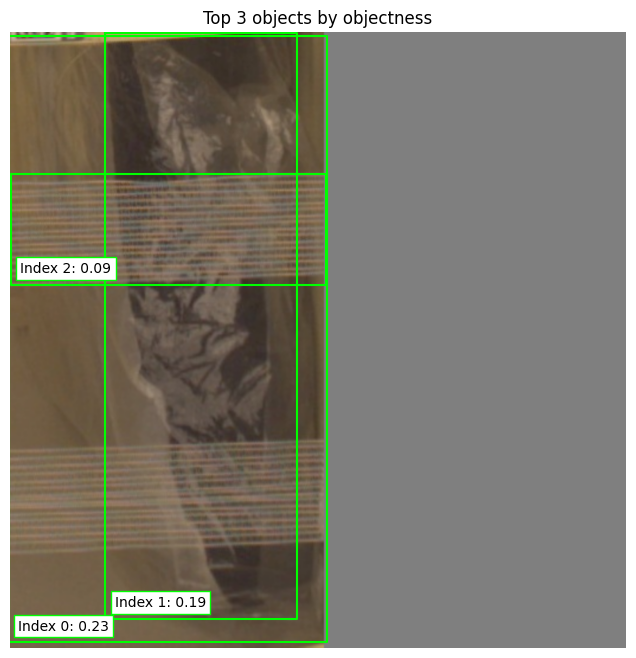

In [21]:
import torch

query = bin_queries[0]
qitem_image, qbin_image, tbin_images, _ = prepare_by_bboxcrop(query)
padded_qitem_image = get_preprocessed_image(qitem_image)

top_k=3
query_embeddings, boxes, scores = get_embed_by_objectness(qitem_image, top_k=top_k)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(padded_qitem_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for i, (box, score) in enumerate(zip(boxes, scores)):
  cx, cy, w, h = box
  ax.plot(
      [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
      [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
      color='lime',
  )
  ax.text(
      cx - w / 2 + 0.015,
      cy + h / 2 - 0.015,
      f'Index {i}: {score:1.2f}',
      ha='left',
      va='bottom',
      color='black',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'lime',
          'boxstyle': 'square,pad=.3',
      },
  )

ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Top {top_k} objects by objectness')
plt.show()

Number of boxes filtered,  4


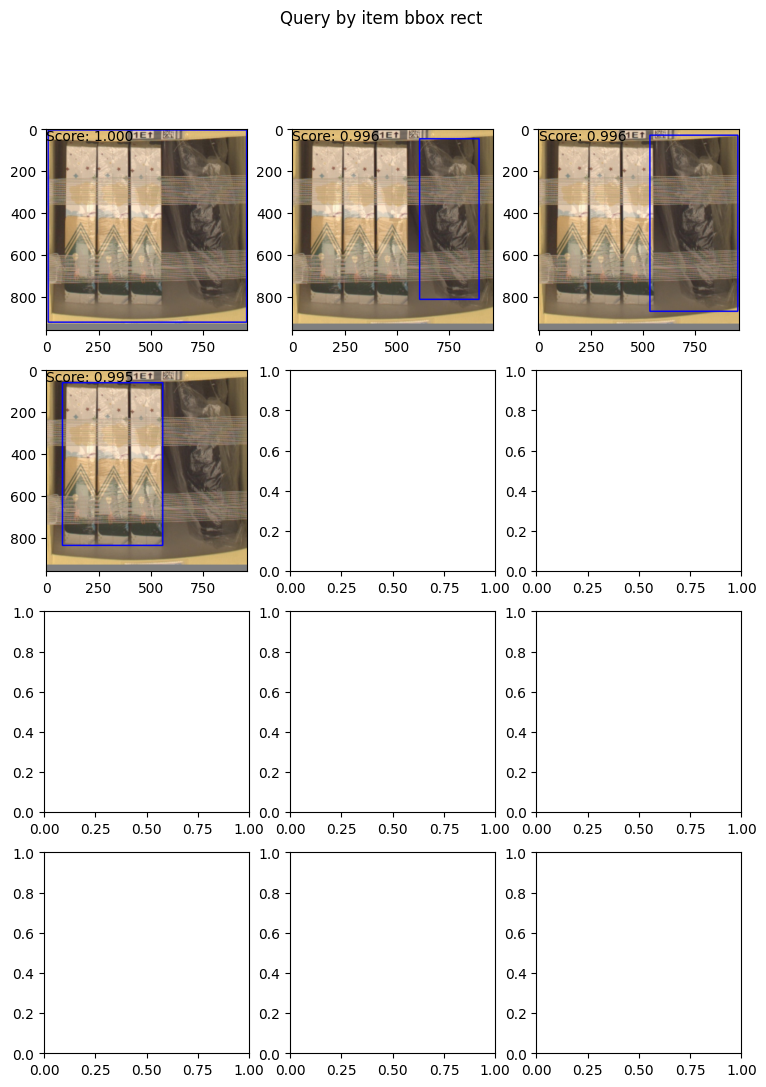

In [22]:
box_scores = query_in_image(
    target_images=tbin_images[0].unsqueeze(0),
    query_embeddings=query_embeddings[0].unsqueeze(0),
    score_threshold=0.99,
    nms_threshold=0.9
)

# Plot the bboxes on the grid with one bbox per grid cell.
print("Number of boxes filtered, ", len(box_scores[0]))

padded_target_image = get_preprocessed_image(tbin_images[0])
show_bbox_ingrid(
    np.array(padded_target_image), 
    box_scores[0], 
    (4, 3), 
    "Query by item bbox rect")

[0.2545839 0.5       0.5091678 1.       ]


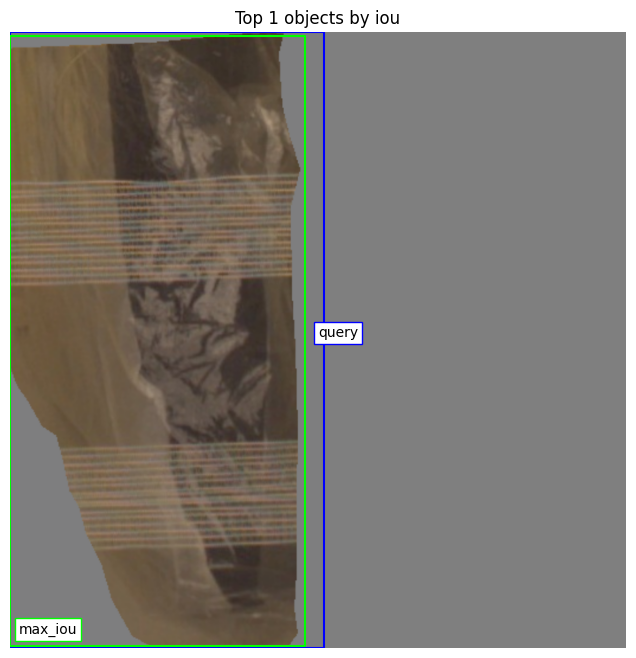

In [23]:
query = bin_queries[0]
qitem_image, qbin_image, tbin_images, bbox = prepare_by_bboxseg(query)
padded_qitem_image = get_preprocessed_image(qitem_image)
print(bbox)

query_embeddings, boxes, _ = get_embed_by_maxiou(qitem_image, bbox)
# print(embeddings.shape, boxes.shape)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(padded_qitem_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

cx, cy, w, h = bbox
ax.plot(
    [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
    [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
    color='blue',
)
ax.text(
    cx - w / 2 + 0.5,
    cy + h / 2 - 0.5,
    'query',
    ha='left',
    va='bottom',
    color='black',
    bbox={
        'facecolor': 'white',
        'edgecolor': 'blue',
        'boxstyle': 'square,pad=.3',
    },
)

cx, cy, w, h = boxes[0]
ax.plot(
    [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
    [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
    color='lime',
)
ax.text(
    cx - w / 2 + 0.015,
    cy + h / 2 - 0.015,
    'max_iou',
    ha='left',
    va='bottom',
    color='black',
    bbox={
        'facecolor': 'white',
        'edgecolor': 'lime',
        'boxstyle': 'square,pad=.3',
    },
)
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_title(f'Top 1 objects by iou')
plt.show()

Number of boxes filtered,  5


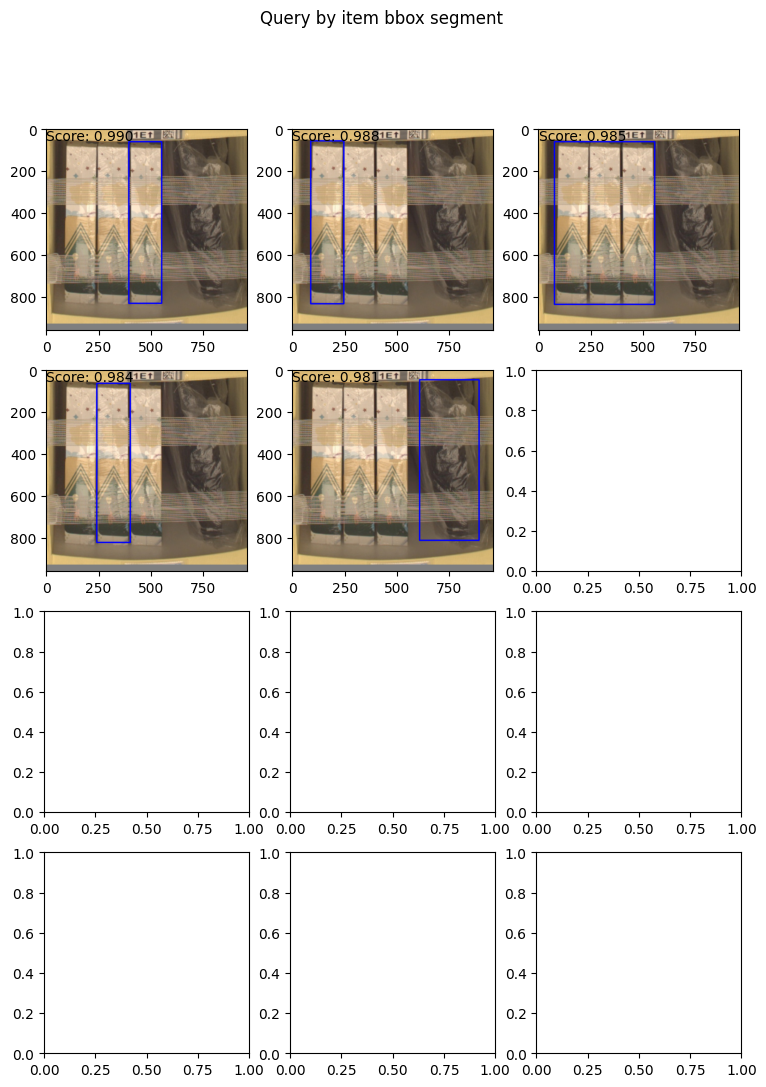

In [24]:
box_scores = query_in_image(
    target_images=tbin_images[0].unsqueeze(0),
    query_embeddings=query_embeddings[0].unsqueeze(0),
    score_threshold=0.98,
    nms_threshold=0.9
)

# Plot the bboxes on the grid with one bbox per grid cell.
print("Number of boxes filtered, ", len(box_scores[0]))

padded_target_image = get_preprocessed_image(tbin_images[0])
show_bbox_ingrid(
    np.array(padded_target_image), 
    box_scores[0], 
    (4, 3), 
    "Query by item bbox segment")